Анастасия Костяницына 

Устинья Кошелева

In [1]:
import pandas as pd

# Данные 

Посмотрим на данные 

In [2]:
train = pd.read_csv('/Users/Stoneberry/Downloads/train.csv')
test = pd.read_csv('/Users/Stoneberry/Downloads/test.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [7]:
from matplotlib.pyplot import hist

(array([1225312.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   80810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

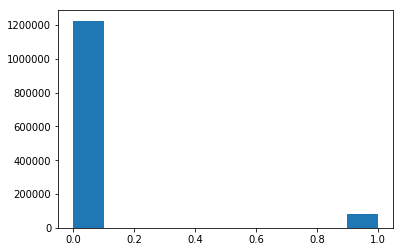

In [8]:
hist(train.target)

1 - insincere (toxic)

Текстов, которые отностся к классу не токсичных, значительно больше. Выделим их в отдельную переменную.

In [9]:
toxic = train.loc[train['target'] == 1]

In [12]:
toxic.shape

(80810, 3)

# Сделаем равное кол-во строчек для каждого класса

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import random 

In [15]:
nottoxic = train.loc[train['target'] == 0]
ids = random.sample(nottoxic.qid.tolist(), 80810)

In [22]:
array = ['yellow', 'green']
X_train = train.loc[train['qid'].isin(ids)]

In [27]:
X_train.head()

,qid,question_text,target
32,00017146167b4072ae5f,If lightsabers are created by individual wield...,0
41,0001b70b617623c8ec11,What is the role of technology in using a reso...,0
43,0001d772cf3019016119,Where can I download Microsoft Word for Window...,0
49,00021a90cbe0ce61b32a,Why most of the computer science student buy f...,0
67,0002f70cd6c744df04fb,"What are the biggest problems, questions, doub...",0


In [29]:
X_train = pd.concat([X_train, toxic])

In [31]:
X_train.shape

(161620, 3)

Tfidf

In [305]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_train.question_text)

In [36]:
X.shape

(161620, 1000)

# Обучаем

Это мы решили посмотреть как вообще классифицируются данные, чтобы понять, хотим ли мы этим заниматься. 

In [319]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score

In [38]:
y = X_train.target

In [39]:
y.shape

(161620,)

In [43]:
est = LogisticRegression(class_weight='balanced', random_state=42)
np.mean(cross_val_score(est, X, y, cv=3))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.859658478435625

Подбор парам.

In [46]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, random_state=1)

In [47]:
params = {'C':[1, 10, 100, 100]}
est = LogisticRegression(class_weight='balanced', random_state=42)
clf = GridSearchCV(est, params, cv=3)
clf.fit(train_X, train_y)
clf.best_params_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 10}

In [50]:
est = LogisticRegression(class_weight='balanced', random_state=42, C=10)
est.fit(train_X, train_y)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [306]:
pred = est.predict(valid_X)

In [55]:
accuracy_score(valid_y, pred)

0.8623932681598812

# Тематический расизм

Идея - определит топики по тем данным, которые относятся к классу "токсичный", посмотреть встречается ли тема расизма, например, в не токсичных данных, посмотреть на данные, есть ли что-то, что позволяется отнести токсиный документы к категории нетоксичных, или это ошибка разметки?

In [133]:
import gensim
import json
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pyLDAvis.gensim
import string
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [134]:
stops = set(stopwords.words('english'))

In [110]:
def normalize(words):
    norm_words = [lmtzr.lemmatize(word) for word in words if len(set(word)) > 1]
    return norm_words

def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:lmtzr.lemmatize(word) for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.strip(string.punctuation) for word in text.split()]
    words = [word for word in words if word]
    
    return words

In [77]:
string.punctuation += '/'

In [94]:
toxic.question_text[22]

'Has the United States become the largest dictatorship in the world?'

#### Без н-грамм, без улучшенного словаря

In [274]:
import pickle

In [ ]:
with open('/Users/Stoneberry/Downloads/d.pickle', 'wb') as f:
    pickle.dump(texts, f)

In [302]:
with open('/Users/Stoneberry/Downloads/not_t.pickle', 'wb') as f:
    pickle.dump(random.sample(nontox_lists, 80810), f)

In [135]:
texts = opt_normalize([tokenize(text.lower()) for text in toxic.question_text], 35000)

In [109]:
texts[0]

['ha', 'united', 'state', 'become', 'largest', 'dictatorship', 'world']

## LDA модели

In [115]:
def my_lda(texts, num_topics=10, passes=10, eta='auto', tf=False):
            
    dictinary = gensim.corpora.Dictionary(texts)
    dictinary.filter_extremes(no_above=0.3)
    dictinary.compactify()
    
    corpus = [dictinary.doc2bow(text) for text in texts]
    
    if tf:
        tfidf = gensim.models.TfidfModel(corpus, id2word=dictinary)
        corpus = tfidf[corpus]

    lda = gensim.models.LdaModel(corpus, id2word=dictinary, 
                                 passes=passes, num_topics=num_topics,
                                 eta=eta, random_state=42)
    return lda

In [116]:
import pandas as pd


def words(lda):
    d = {}

    for index, line in enumerate(lda.print_topics()):
        d[index] = re.findall('"(.*?)"', line[1])
    
    return pd.DataFrame(d)

In [136]:
lda = my_lda(texts)

In [137]:
table1 = words(lda)

In [138]:
table1

,0,1,2,3,4,5,6,7,8,9
0,child,trump,modi,woman,indian,people,country,wa,muslim,sex
1,would,quora,wa,men,girl,white,american,school,india,want
2,democrat,people,hitler,guy,year,black,world,kid,people,get
3,trump,liberal,force,like,north,chinese,u,earth,hindu,gay
4,obama,question,house,man,old,american,jew,fake,indian,would
5,wa,doe,destroy,girl,like,hate,america,student,islam,doe
6,liberal,donald,germany,male,india,like,state,news,christian,best
7,party,god,tax,rape,boy,racist,people,real,religion,dog
8,republican,many,trying,feminist,even,asian,usa,day,pakistan,sister
9,immigrant,think,created,female,stop,think,israel,time,country,make


Кажется, что лучше всего выделилась тема 5 и 8 (расизм), посмотрим, как они соотносятся с non toxic texts. (Тему 5 мы решили не использовать, так как мы посмотрели по результам, слова like и hate добавляют много fp ответов)

Построим все для конкретного примера

In [166]:
dictinary = gensim.corpora.Dictionary(texts)
dictinary.filter_extremes(no_above=0.3)
dictinary.compactify()
corpus = [dictinary.doc2bow(text) for text in texts]
lda = gensim.models.LdaModel(corpus, id2word=dictinary, 
                                 passes=10, num_topics=10,
                                 eta='auto', random_state=42)

Посмотрим к каким текстам применима 8 тема (расизм)

In [196]:
indx_text = {index:text for index, text in enumerate(nottoxic.question_text)}
text_indx = {text:index for index, text in enumerate(nottoxic.question_text)}

In [167]:
nontox_lists = opt_normalize([tokenize(text.lower()) for text in nottoxic.question_text], 35000)

In [171]:
from tqdm import tqdm_notebook

In [172]:
res = []

t_par = tqdm_notebook(nontox_lists, desc='doc', leave=True)

for d in t_par:
    bow = dictinary.doc2bow(d)
    t = lda.get_document_topics(bow)
    res.append(t)

In [214]:
d = {'score':[], 'doc':[]}

for index, item in enumerate(res):
    a = [i for i in item if i[0] == 8 and i[1] >= 0.75]
    if a != []:
        d['score'].append(a[0][1])
        d['doc'].append(indx_text[index])

In [215]:
df = pd.DataFrame(d)

Сортируем по скору

In [217]:
df.sort_values(by=['score'])

,doc,score
1110,Does every country speak a different type of E...,0.751753
1323,Dissolving the Article 370 can help stabilise ...,0.752080
1207,Apart from the Muslim clerics how many of the ...,0.752150
729,There are many people who have no inner peace....,0.752157
1650,Why don't Islamic terrorists attack Malaysia a...,0.753414
1782,When foreigners speak English with their accen...,0.753560
731,What should common Indian Muslim do to not cal...,0.754618
43,When will Hindus become minority and Muslims b...,0.755808
1250,What do people in neighborhing countries like ...,0.756003
513,"As a Muslim, what do you want to say to people...",0.757133


In [207]:
df.loc[2695].doc

'Is it true that only white people can be racist?'

In [227]:
df.loc[1399].doc

"Why do Muslims believe the majority of non Muslims don't understand Islam?"

In [249]:
df.loc[63].doc

'Do Indians that hate Islam and Muslims hate the faith and people because of Pakistan?'

In [250]:
df.loc[186].doc

'Why does Pakistan is such a bad country and also supports terrorist?'

Как видно уже на этих примерах, к классу нетоксичных отнесены и сопвершенно противоположные документы. 

Проверим, есть ли нетоксичные документы в категории токсичных. 

### Для toxic

In [220]:
res2 = []

t_par = tqdm_notebook(texts, desc='doc', leave=True)

for d in t_par:
    bow = dictinary.doc2bow(d)
    t = lda.get_document_topics(bow)
    res2.append(t)

In [221]:
indx_text_tox = {index:text for index, text in enumerate(toxic.question_text)}

In [224]:
d2 = {'score':[], 'doc':[]}

for index, item in enumerate(res2):
    a = [i for i in item if i[0] == 8 and i[1] >= 0.75]
    if a != []:
        d2['score'].append(a[0][1])
        d2['doc'].append(indx_text_tox[index])

In [228]:
df2 = pd.DataFrame(d2).sort_values(by=['score'])

In [231]:
df2

,doc,score
7,Why is there so any people who are in Toronto ...,0.750282
278,Are all Indian Muslims slaves of Saudi Arabia?...,0.751286
35,How many licks does it take to make Oprah expl...,0.751306
270,Why do many people consider the crusaders to h...,0.753594
171,"If a nation becomes majority Muslim, does it b...",0.755231
302,As a Muslim who have good knowledge of Quran a...,0.756107
63,Do you think that Indian Muslims are intention...,0.756616
267,Will India become a developed nation if all In...,0.758197
122,Why Indian Hindus can't bear the presence of M...,0.758204
221,Why don't Muslims establish freedom in their o...,0.759388


In [255]:
df2.loc[167].doc

'Why do people that like Jake Paul dislike Logan Paul?'

In [256]:
df2.loc[211].doc

'Who do you think is worse for society: Logan Paul or Jake Paul?'

In [257]:
df2.loc[10].doc

'Who started the saying, “Grab her by the Trump”?'

Why did Neil Armstrong return back to Earth instead of landing on the Moon?

Is it possible to have syphilis and not have symptoms?

Why are so many Indians poor? 

How does Luminary Cream function?

Why can't I install AMD on an Intel processor?

Is it possible to have syphilis and not have symptoms

И тут есть документы, которые явно не принадлежат своему классу. Посмотрим, есть ли какие-то закономерности.

#### Частотные слова:

In [ ]:
from collections 

In [234]:
count_nont = Counter()
for d in nontox_lists:
    count_nont.update(d)    

In [235]:
count_t = Counter()
for d in texts:
    count_t.update(d)    

In [245]:
tox = {i[0] for i in count_t.most_common(20)} - set(table1[8])
not_tox = {i[0] for i in count_nont.most_common(20)} - set(table1[8])

In [248]:
tox

{'american',
 'black',
 'doe',
 'get',
 'girl',
 'like',
 'many',
 'men',
 'quora',
 'think',
 'trump',
 'wa',
 'white',
 'woman',
 'would'}

In [247]:
not_tox

{'best',
 'doe',
 'get',
 'good',
 'ha',
 'life',
 'like',
 'make',
 'many',
 'much',
 'one',
 'someone',
 'think',
 'time',
 'wa',
 'way',
 'would',
 'year'}

Набор слов отличается, однако нужно учитывать то, что тексто для нетоксичного класса намного больше, и то, что вообще набор слов для токсик не является таким уж однозначно показательным. 

#### N-gramm

In [279]:
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4) 
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts]

In [284]:
ph2 = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4)
p2 = gensim.models.phrases.Phraser(ph2)
ngrammed_non = p2[nontox_lists]

In [298]:
count_nont = Counter()
for d in ngrammed_non:
    for i in d:
        if '_' in i:
            count_nont[i]+= 1    

count_t = Counter()
for d in ngrammed_texts:
    for i in d:
        if '_' in i:
            count_t[i] += 1

In [299]:
tox = {i[0] for i in count_t.most_common(20)} 
not_tox = {i[0] for i in count_nont.most_common(20)}

In [317]:
tox & not_tox

{'doe_mean',
 'donald_trump',
 'even_though',
 'look_like',
 'north_korea',
 'united_state',
 'would_happen',
 'year_old'}

In [ ]:
Достаточно 

In [300]:
tox

{'act_like',
 'african_american',
 'doe_mean',
 'donald_trump',
 'even_though',
 'gun_control',
 'hillary_clinton',
 'illegal_immigrant',
 'look_like',
 'middle_east',
 'narendra_modi',
 'native_american',
 'north_indian',
 'north_korea',
 'president_trump',
 'south_indian',
 'trump_supporter',
 'united_state',
 'would_happen',
 'year_old'}

In [301]:
not_tox

{'best_way',
 'doe_mean',
 'donald_trump',
 'even_though',
 'get_rid',
 'good_idea',
 'high_school',
 'jee_main',
 'look_like',
 'new_york',
 'north_korea',
 'pro_con',
 'real_estate',
 'social_medium',
 'tv_show',
 'united_state',
 "what's_best",
 "what's_difference",
 'would_happen',
 'year_old'}

Би-граммы тоже не особо показательны

### Порядок слов

In [ ]:
import nltk
from nltk import pos_tag

In [326]:
pos_tag(tox[0])

NameError: name 'pos_tag' is not defined

In [325]:
import pickle

with open('/Users/Stoneberry/Downloads/tox_tagged.pickle', 'rb') as f:
    tox = pickle.load(f)

with open('/Users/Stoneberry/Downloads/nottox_tagged.pickle', 'rb') as f:
    nottox = pickle.load(f)


words = ['muslim', 'indian', 'christian', 'arab', 'hindu']
words = words + [i + 's' for i in words]

In [336]:
def count_w_verb(texts, tox):
    count_wverb = 0
    count_wother = 0

    t_par = tqdm_notebook(texts, desc='doc', leave=True)

    for index, text in enumerate(t_par):

        tags = tox[index] #pos_tag(text)

        for i, w in enumerate(tags):
            if w[0] in words and i < len(tags) - 1 and tags[i + 1][1] == 'VBN':
                count_wverb += 1
            elif w[0] in words:
                count_wother += 1
    return count_wverb, count_wother


Токсичные тексты:

In [337]:
count_w_verb(texts, tox)

(234, 14734)

In [338]:
234/(14734 + 234)

0.015633351149118117

Нетоксичные тексты:

In [339]:
count_w_verb(texts, nottox)

(14, 1263)

In [340]:
14/(14 + 1263)

0.01096319498825372

У нас было предположение, что в токсичных текстах скорее всего будет преобладать конструкции типа национальность + глагол. Но это не оправдалось. 

Скорее всего, то, что негативные примеры вошли в состав, является ошибкой разметчиков. Такой способо может быть полезным в поиске неправильно классифицированных текстов для очистки тренировочной выборки. Возможно, это может улучшить классификацию.  

## Подбор 
Тут мы пытались подобрать параметры, чтобы получить хорошие темы, но первоначальные все таки были лучше.

#### Улучшим словарь:

In [119]:
all_t = Counter([])
for lst in texts:
    all_t += Counter(lst)

In [122]:
stops_t = {i[0] for i in all_t.most_common(50)}
least_t = {i[0] for i in all_t.most_common()[:-100-1:-1]}
stops = stops | stops_t | least_t

In [125]:
texts_new_stops = opt_normalize([tokenize(text.lower()) for text in toxic.question_text], 35000)

In [128]:
lda = my_lda(texts_new_stops)
words(lda)

,0,1,2,3,4,5,6,7,8,9
0,racist,modi,gun,obama,israel,guy,answer,male,religion,god
1,asian,hillary,day,terrorist,human,north,conservative,law,islam,atheist
2,usa,clinton,go,pakistani,dog,bad,culture,feminist,love,stupid
3,european,supporter,boy,attack,eat,party,look,female,wrong,iq
4,african,fake,old,nothing,pakistan,rape,money,poor,ever,earth
5,race,election,man,tamil,palestinian,big,sexual,take,sister,everyone
6,british,bjp,i'm,allow,animal,good,word,million,mother,ask
7,western,government,control,support,become,penis,find,long,kill,respect
8,china,leader,every,name,jesus,okay,seem,wear,parent,anyone
9,immigrant,vote,daughter,pakistan,baby,south,compared,care,tell,really


#### Разные параметры

In [320]:
lda2 = my_lda(texts, num_topics=50, passes=5)
table2 = words(lda2)
table2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,say,gun,thing,life,african,white,feel,trump,hate,friend,liberal,chinese,mean,tell,year,considered,muslim,look,woman,become
1,call,use,israel,given,allowed,black,everyone,president,much,away,conservative,come,live,put,still,anything,india,stupid,men,understand
2,mother,control,realize,face,issue,people,lot,donald,jew,using,medium,people,doe,word,old,used,pakistan,like,man,start
3,people,two,rape,cat,age,racist,lie,obama,state,rich,anyone,today,based,fuck,hillary,got,left,new,like,sexual
4,baby,pay,reason,wish,created,give,living,ever,people,it’s,don’t,china,belief,well,actually,power,country,citizen,young,hard
5,know,long,okay,quorans,dick,race,doe,doe,united,troll,death,enjoy,cause,they're,clinton,evidence,majority,people,single,ugly
6,english,bible,around,meat,suck,arab,like,wa,west,number,u.s,behind,forced,germany,kid,action,allow,nazi,comment,would
7,speak,home,palestinian,drug,intelligent,american,site,ha,consider,canadian,view,many,ashamed,superior,rather,stand,islam,dumb,husband,matter
8,wife,buy,victim,please,american,especially,likely,slave,leader,hand,social,false,muhammad,holocaust,wa,virgin,keep,almost,get,castrated
9,mexican,simply,really,spend,standard,racism,city,making,korean,can’t,due,interested,water,calling,normal,dating,christian,stay,want,office


In [323]:
lda2 = my_lda(texts, num_topics=50, passes=15)
table2 = words(lda2)
table2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thing,friend,answer,guy,muslim,big,trump,better,child,supporter,girl,stop,terrorist,war,white,become,tell,time,gun,life
1,israel,away,instead,love,india,jewish,president,someone,kill,show,boy,post,law,best,black,understand,put,every,use,given
2,rape,using,history,need,pakistan,group,donald,help,without,population,like,far,uk,going,people,start,word,money,control,face
3,realize,rich,change,real,left,killing,obama,trying,russia,vote,community,lose,attack,etc,racist,sexual,fuck,male,two,cat
4,reason,it’s,trump's,first,country,people,ever,said,eat,student,feeling,could,modern,poor,give,hard,well,day,pay,wish
5,okay,troll,free,another,majority,million,doe,ok,support,public,allah,pregnant,rule,order,race,ugly,they're,female,long,quorans
6,around,number,german,marry,allow,genocide,ha,else,let,jesus,join,wall,fight,seems,arab,would,germany,work,bible,meat
7,palestinian,canadian,prefer,military,islam,weapon,wa,people,done,body,hold,health,brain,food,american,matter,superior,immigrant,home,please
8,really,can’t,speech,abortion,keep,nuclear,slave,greek,police,foreign,theist,get,syria,save,especially,castrated,holocaust,illegal,buy,drug
9,victim,hand,dress,transgender,christian,crazy,making,would,would,skin,always,generation,feminism,like,racism,office,calling,place,simply,spend


In [324]:
lda2 = my_lda(texts, num_topics=100, passes=5)
table2 = words(lda2)
table2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,medium,feel,bad,mean,look,try,way,make,give,new,republican,anything,year,jew,good,arab,country,many,fact,user
1,refugee,eat,happen,consider,call,young,best,since,got,relationship,party,west,china,live,man,islamic,european,find,lie,intelligence
2,lazy,seen,end,today,family,average,based,well,birth,able,called,said,old,part,friend,rule,western,people,penis,biased
3,prison,like,full,doe,around,raped,education,fat,deny,important,iq,intelligent,nation,palestinian,voted,sense,allow,american,wife,anymore
4,wanted,ashamed,looking,greek,like,leave,dress,people,voter,easily,high,already,history,israeli,expect,nuclear,american,considering,issue,gas
5,powerful,doe,would,action,term,abuse,forced,non,google,guilty,evidence,car,ok,german,admit,iranian,middle,weird,what's,farm
6,sent,hatred,politics,violent,national,past,demand,doe,zionist,university,standard,drink,age,cause,hit,dirty,like,self,post,compare
7,camp,boyfriend,bed,italian,meat,found,fighting,prevent,trade,trans,dark,cow,rest,israel,want,report,wish,offended,comment,illegals
8,trust,people,people,talking,doe,dead,8,global,related,aid,suffering,medicine,transgender,holocaust,writing,smarter,finally,constantly,game,giant
9,mainstream,he’s,royal,value,people,eye,main,moon,multiple,besides,following,exists,bring,buy,provide,regime,isn’t,collusion,book,oral


### C Tf

In [321]:
lda3 = my_lda(texts, num_topics=50, passes=10, eta='auto', tf=True)
table = words(lda3)

In [322]:
table 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,dog,penis,full,iq,obsessed,western,marry,parent,republican,baby,fuck,fake,society,suck,thought,ugly,beautiful,old,sex,asian
1,modi,small,idea,born,russian,culture,history,die,party,speak,superior,europe,getting,among,legal,money,allowed,date,sister,white
2,conservative,death,pussy,father,trump's,destroy,respect,exist,citizen,english,they're,news,filipino,move,porn,far,brother,leftist,mother,racist
3,especially,army,japan,low,answer,great,what's,australian,cousin,hindi,fucking,language,slavery,turk,put,pregnant,vote,consider,mom,african
4,muslim,2,military,long,jesus,bjp,though,paid,democrat,election,doctor,young,past,corrupt,feminism,picture,age,year,daughter,black
5,happen,found,next,average,russia,land,lie,color,run,problem,teacher,africa,false,send,faith,mostly,created,u.s,son,people
6,join,game,freedom,fight,west,act,bring,bigger,democratic,rather,calling,dress,choose,bed,street,home,issue,prove,raped,look
7,living,hit,class,around,quora,weird,human,difference,new,ban,easily,rude,educated,follower,talking,wall,convince,school,tell,woman
8,convert,caused,lost,learn,name,treat,virgin,autistic,left,important,threat,everyone,away,story,hold,3,smart,looking,truth,american
9,church,kerala,soldier,incest,last,argument,lose,fun,christianity,rest,murder,nation,protest,two,watch,officer,top,prostitute,want,race
